In [7]:
!pip install -r requirements.txt

In [8]:
# # Connect with drive
# from google.colab import drive
# drive.mount('/content/drive')

## Import modules

In [9]:
# Image processing
import cv2

# Numeral processing
import numpy as np
from numpy import linalg
import pandas as pd

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns


# Tensorflow + Keras
import tensorflow as tf

# Sklearn: SVC + PCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [10]:
# Global Variables
ROOT_DIR = './'
# ROOT_DIR = "/content/drive/My Drive/Colab Notebooks/" #For google path in drive

## Data Preprocessing

In [11]:
data = pd.read_csv(ROOT_DIR + "fer2013.csv")
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [12]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [13]:
X = data['pixels']
y = data['emotion']

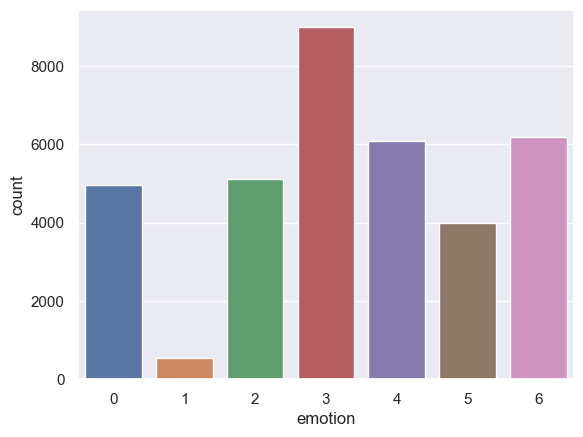

In [14]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)
fig = ax.get_figure()
fig.savefig("count.png")

In [15]:
train_set = data[(data.Usage == 'Training')] 
test_set = data[(data.Usage == 'PrivateTest')] 

In [16]:
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
# X_train = X_train.reshape(X_train.shape[0], 48, 48) 
# X_test = X_test.reshape(X_test.shape[0], 48, 48)

Min-Max normalization: Scale to [0,1]

In [17]:
X_train = X_train/255
X_test = X_test/255

In [18]:
y_train = train_set.emotion  
y_test = test_set.emotion 

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 2304)
(3589, 2304)
(28709,)
(3589,)


### Visualize some images

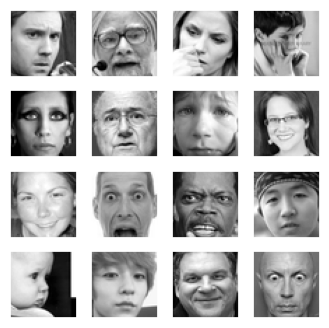

In [20]:
def visualize_subsample_images(data):
    data_ = data.reshape(data.shape[0], 48, 48) 
    _,axxr = plt.subplots(4,4, figsize=(4,4))
    for i in range(4):
        for j in range(4):
            axxr[i][j].imshow(data_[i*4+j], cmap='gray')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.savefig('sample.png')
    # plt.show()

visualize_subsample_images(X_train)

### Feature extraction with PCA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


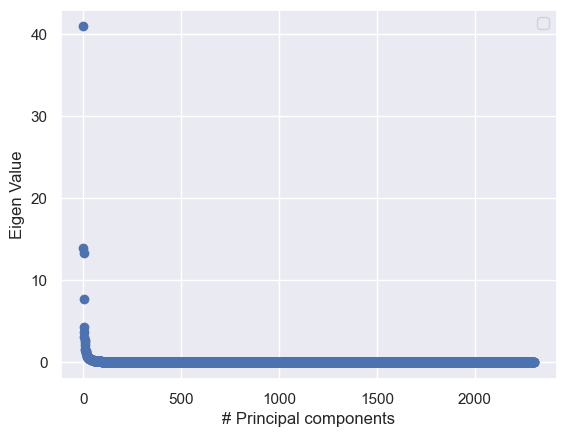

<Figure size 640x480 with 0 Axes>

In [21]:
cov = np.cov(X_train.T)
eig_val, eig_vec = np.linalg.eig(cov)
eigen_values_sorted = np.argsort(-eig_val)
plt.ylabel('Eigen Value')
plt.xlabel('# Principal components')
plt.legend(loc = 'best')
plt.scatter(range(eig_val.shape[0]),eig_val[eigen_values_sorted])
plt.figure()
plt.tight_layout()
plt.savefig("pca.png")
plt.show()

In [22]:
!pip install kneed
from kneed import KneeLocator
kn = KneeLocator(range(eig_val.shape[0]),eig_val[eigen_values_sorted], curve='convex', direction='decreasing')
print(kn.knee) # 28

28


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


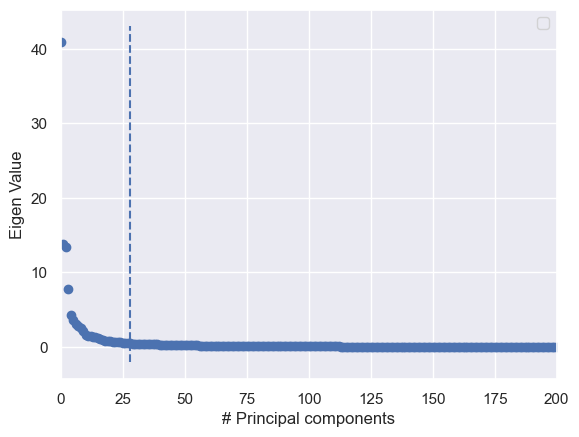

<Figure size 640x480 with 0 Axes>

In [23]:
cov = np.cov(X_train.T)
eig_val, eig_vec = np.linalg.eig(cov)
eigen_values_sorted = np.argsort(-eig_val)
plt.ylabel('Eigen Value')
plt.xlabel('# Principal components')
# plt.ylim(-10, 500000)
plt.xlim(0, 200)
plt.legend(loc = 'best')
plt.scatter(range(eig_val.shape[0]),eig_val[eigen_values_sorted])
plt.vlines(28, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.figure()
plt.tight_layout()
plt.savefig("pca_after.png")
plt.show()

So n_features = 28 is the elbow point of this graph. So we choose 28 is the n_components in PCA

In [24]:
# Fit PCA model
pca = PCA(n_components=28, whiten=True).fit(X_train) 

# PCA
X_train_pca = pca.transform(X_train) # (_,28)
X_test_pca = pca.transform(X_test)  # (_,28)

## Train a model

In [25]:
# 'C': [1/(2<<i) for i in range(4,-1,-1)] + [1] + [2<<i for i in range(14)],
# 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
# GridSearchCV, param_grid

svc = SVC(kernel='rbf',  # 'rbf', 'linear', 'poly' or 'sigmoid'
        decision_function_shape = 'ovr',  # 'ovo' for OneVsOne and 'ovr' for OneVsRest'
        max_iter = 10000,
        gamma = 'auto', # use a float number or 'auto' 
        class_weight = 'balanced',
        # verbose = True
    )
clf_svc = svc.fit(X_train_pca, y_train)
y_pred = clf_svc.predict(X_test_pca)
print('Accuracy Score: ', accuracy_score(y_test,y_pred))

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score:  0.4224017832265255


## Evaluate model

Classfication Report: 
               precision    recall  f1-score   support

           0       0.32      0.33      0.33       491
           1       0.19      0.56      0.28        55
           2       0.33      0.25      0.28       528
           3       0.58      0.55      0.56       879
           4       0.37      0.37      0.37       594
           5       0.51      0.59      0.55       416
           6       0.40      0.39      0.40       626

    accuracy                           0.42      3589
   macro avg       0.39      0.43      0.40      3589
weighted avg       0.43      0.42      0.42      3589

@@@@@  The heat map of this method is showed in the picture below   @@@@@@


2022-12-07 00:20:00.496142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


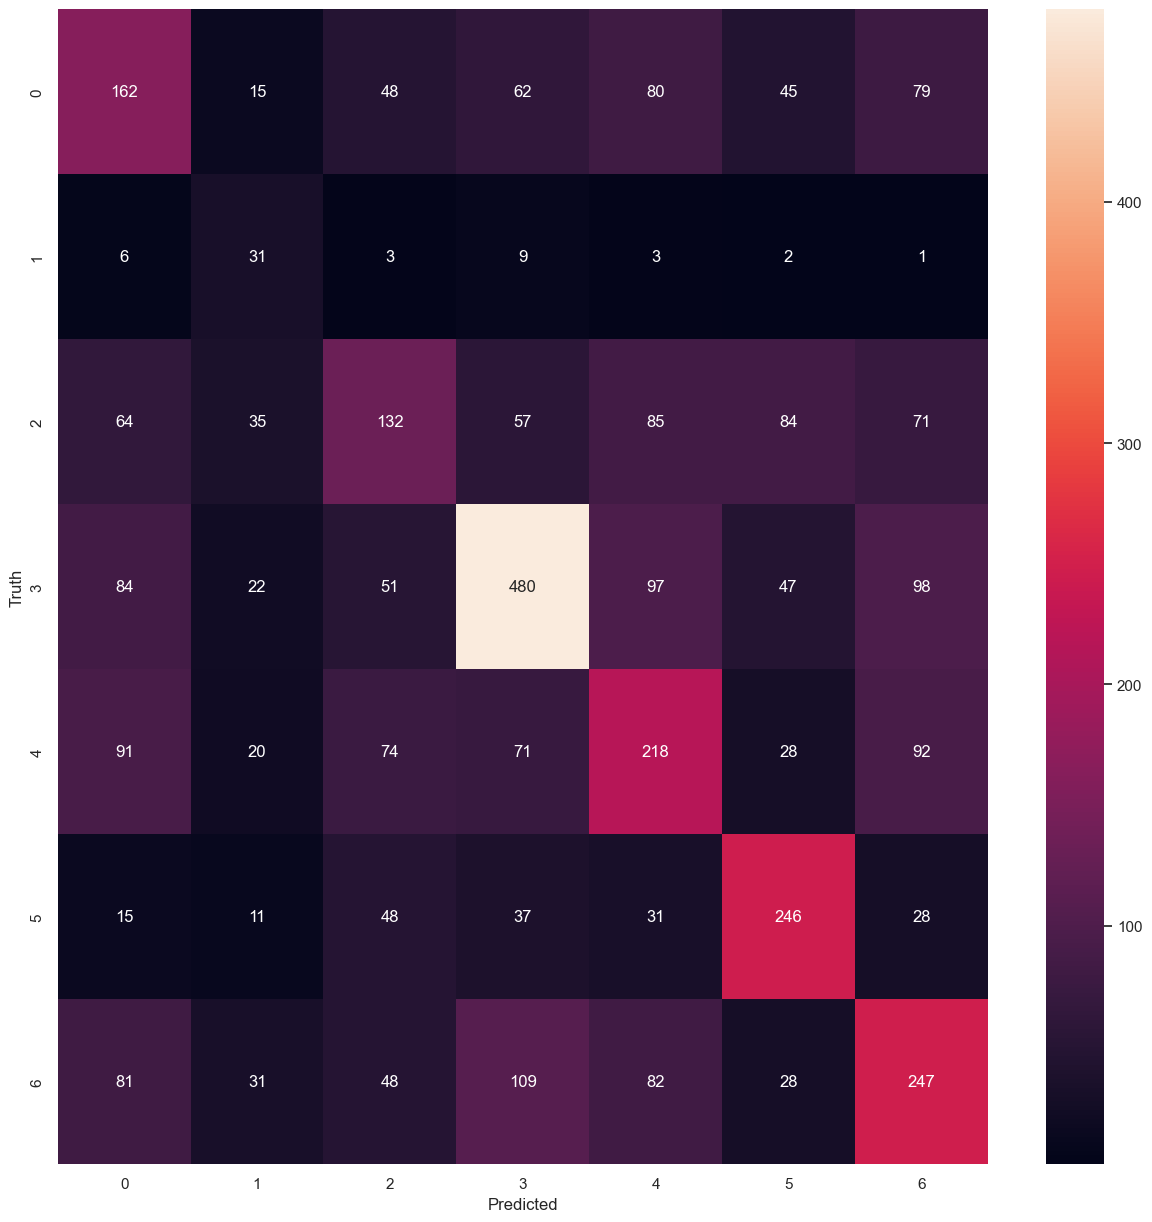

In [26]:
# Evaluate the accuracy of model using heat map
def evaluate_model(y_test, y_pred):
    print("Classfication Report: \n", classification_report(y_test, y_pred))
    print("@@@@@  The heat map of this method is showed in the picture below   @@@@@@")
    cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)
    plt.figure(figsize=(15,15))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.savefig('confusion_matrix.png')
    plt.show()

evaluate_model(y_test,y_pred)

In [ ]:
!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train_pca, X_test_pca, y_train, y_test)
models.to_csv("fer_benchmark.csv")
models

## Save and load SVM model

In [30]:
!pip install joblib
import joblib
filename = 'svm_model.sav'
joblib.dump(clf_svc, filename)

['svm_model.sav']

In [31]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test_pca, y_test)
print(result)

0.4224017832265255
